In [1]:
import SimpleITK as sitk
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pydicom as dicom
import os

In [2]:
def load_itk_image(filename):
        with open(filename) as f:
            contents = f.readlines()
            line = [k for k in contents if k.startswith('TransformMatrix')][0]
            transformM = np.array(line.split(' = ')[1].split(' ')).astype('float')
            transformM = np.round(transformM)
            if np.any( transformM!=np.array([1,0,0, 0, 1, 0, 0, 0, 1])):
                isflip = True
            else:
                isflip = False

        itkimage = sitk.ReadImage(filename)
        numpyImage = sitk.GetArrayFromImage(itkimage)
        
        numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
        numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
        
        return numpyImage, numpyOrigin, numpySpacing,isflip

def lumTrans(img):
        lungwin = np.array([-1200.,600.])
        newimg = (img-lungwin[0])/(lungwin[1]-lungwin[0])
        newimg[newimg<0]=0
        newimg[newimg>1]=1
        newimg = (newimg*255).astype('uint8')
        return newimg

def loadMhdImage(path):
    scan,origin,spacing,isflip = load_itk_image(path)
    im = lumTrans(scan)
    initIndex = im.shape[0] // 2
    img =  cv.cvtColor(im[initIndex],cv.COLOR_GRAY2RGB)
    return img,initIndex

def getMetaDataMhd(path):
    metaData = dict()
    itkimage = sitk.ReadImage(path)
    with open(path,'r') as f:
        for line in f.readlines():
            key = line.split(" = ")[0]
            if key == "Offset" :
                metaData["Origin"] = str(np.array(list(reversed(itkimage.GetOrigin()))))
            elif key == "ElementSpacing":
                metaData["Spacing"] = str(np.array(list(reversed(itkimage.GetSpacing()))))
            else:
                metaData[key] = line.split(" = ")[1].strip()
            # print(line.split(" = ")[0])
            # print(line.split(" = ")[1].strip())
    return metaData

def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    if slices[0].ImagePositionPatient[2] == slices[1].ImagePositionPatient[2]:
        sec_num = 2
        while slices[0].ImagePositionPatient[2] == slices[sec_num].ImagePositionPatient[2]:
            sec_num = sec_num+1
        slice_num = int(len(slices) / sec_num)
        slices.sort(key = lambda x:float(x.InstanceNumber))
        slices = slices[0:slice_num]
        slices.sort(key = lambda x:float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16), np.array([slices[0].SliceThickness, slices[0].PixelSpacing[0], slices[0].PixelSpacing[1]], dtype=np.float32)

[-438.4     -311.67773 -157.67773]


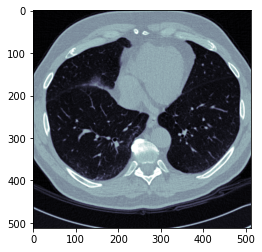

In [3]:
path = "E:/PFE/LUNA/allset/000.mhd"
scan,origin,spacing,isflip = load_itk_image(path)
im = lumTrans(scan[80])
print(origin)
plt.imshow(im,cmap='bone')

In [4]:
data = getMetaDataMhd(path)
print(list(data.keys()))

['ObjectType', 'NDims', 'BinaryData', 'BinaryDataByteOrderMSB', 'CompressedData', 'TransformMatrix', 'Origin', 'CenterOfRotation', 'AnatomicalOrientation', 'Spacing', 'DimSize', 'ElementType', 'ElementDataFile']


(134, 512, 512)
[2.5      0.597656 0.597656]
[-3024 -1024 -1023 ...  1422  1432  1434]


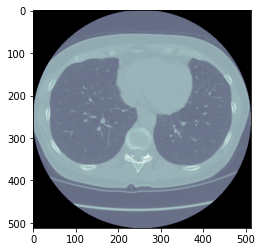

In [5]:
slices = load_scan("E:/PFE/DSB3/stage1/00cba091fa4ad62cc3200a657aeb957e")
slices, spacing = get_pixels_hu(slices)
print(slices.shape)
print(spacing)
print(np.unique(slices[50]))
plt.imshow(slices[50],cmap="bone")

[  0  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255]


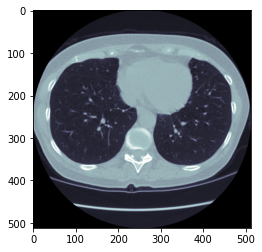

In [6]:
im = lumTrans(slices)
plt.imshow(im[50],cmap="bone")
print(np.unique(im[50]))

In [22]:
def getMetaDataDcm(path):
    metaData = dict()
    att = [(0x0008,0x0016),(0x0008,0x0060),(0x0010,0x0020),(0x0020,0x0011),(0x0020,0x0012),(0x0020,0x0032),(0x0020,0x0037),(0x0028,0x0010),(0x0028,0x0011),(0x0028,0x0030),(0x0028,0x1052),(0x0028,0x1053)]
    listdcmfiles = os.listdir(path)
    dsi = dicom.dcmread(os.path.join(path,listdcmfiles[0]))
    for i in att:
        metaData[dsi[i[0] , i[1]].name] = str(dsi[i[0] , i[1]].value)
    return metaData

In [24]:
metaData = getMetaDataDcm("E:/PFE/DSB3/stage1/00cba091fa4ad62cc3200a657aeb957e")
print(metaData)

{'SOP Class UID': '1.2.840.10008.5.1.4.1.1.2', 'Modality': 'CT', 'Patient ID': '00cba091fa4ad62cc3200a657aeb957e', 'Series Number': '3', 'Acquisition Number': '1', 'Image Position (Patient)': '[-145.500000, -158.199997, -316.200012]', 'Image Orientation (Patient)': '[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]', 'Rows': '512', 'Columns': '512', 'Pixel Spacing': '[0.597656, 0.597656]', 'Rescale Intercept': '-1024', 'Rescale Slope': '1'}
